# Calculate: Effective Radius, Effective Packing Fraction, and Relative RMS Roughness for Particle Species

In [8]:
import pydpmd as dp
from tqdm import tqdm
from pydpmd.plot import draw_particles_frame
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from pydpmd.data import load
import numpy as np
import scipy as sp
from system_building_resources import *
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union

In [9]:
radii = generate_bidisperse_radii(100, 0.5, 1.4)
which = 'small'
packing_fraction = 0.7
phi_increment = 1e-3
temperature = 1e-6
n_steps = 1e5
save_freq = 1e0
dt = 1e-2
pe_tol = 1e-14
n_duplicates_per_system = 10

# build the initial data and equilibrate it, ideally to a 0-overlap state
mu_effs = []
nvs = []
for mu_eff in [0.01, 0.05, 0.1, 0.5, 1.0]:
    for nv in [3, 6, 10, 20, 30]:
        mu_effs.append(mu_eff)
        nvs.append(nv)
assert len(mu_effs) == len(nvs)

cap_nv = 3
add_core = True
# create the systems at a 10% lower density than initially desired so that the duplicate systems have a chance to become sufficiently dissimilar
# this way, we avoid having to create 10x duplicates in the below function which is very slow
rb = build_rigid_bumpy_system_from_radii(radii, which, mu_effs, nvs, packing_fraction, add_core, cap_nv, 'uniform', len(mu_effs))
rb.calculate_mu_eff()

Minimizing
Done


/home/mmccraw/dev/pydpmd/src/pydpmd/data/bumpy_utils.py:5: RuntimeWarning: invalid value encountered in sqrt
  return 1 / np.sqrt(((2 * vertex_radius) / ((outer_radius - vertex_radius) * np.sin(np.pi / num_vertices))) ** 2 - 1)
/home/mmccraw/dev/pydpmd/src/pydpmd/data/bumpy_utils.py:5: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.sqrt(((2 * vertex_radius) / ((outer_radius - vertex_radius) * np.sin(np.pi / num_vertices))) ** 2 - 1)


In [47]:
effective_geometry_data = {
    'phi': [],
    'phi_eff': [],
    'outer_phi_eff': [],
    'sigma_eff_small': [],
    'sigma_eff_large': [],
    'relative_rms_roughness_small': [],
    'relative_rms_roughness_large': [],
    'outer_sigma_small': [],
    'outer_sigma_large': [],
    'mu_eff': [],
    'nv': [],
    'sigma_v_ratio_small': [],
    'sigma_v_ratio_large': []
}
for sid in range(rb.n_systems()):
    # small particles
    vpos = rb.vertex_pos[rb.vertex_particle_id == rb.system_offset[sid]]
    vrad = rb.vertex_rad[rb.vertex_particle_id == rb.system_offset[sid]]
    ppos = rb.pos[rb.system_offset[sid]]
    rad = rb.rad[rb.system_offset[sid]]
    true_area_small = rb.area[rb.system_offset[sid]]
    exterior = np.array(unary_union([Point(pos).buffer(rad, quad_segs=1e5) for pos, rad in zip(vpos, vrad)]).exterior.coords)
    profile = np.linalg.norm(exterior - ppos, axis=1)
    sigma_eff_small = 2 * np.mean(profile)
    relative_rms_roughness_small = 2 * np.sqrt(np.mean((profile - sigma_eff_small / 2) ** 2)) / sigma_eff_small
    outer_sigma_small = 2 * rad
    N_small = np.sum(rb.rad[rb.system_offset[sid]:rb.system_offset[sid + 1]] == rad)
    sigma_v_ratio_small = rb.vertex_rad[rb.vertex_system_offset[sid]] / rad

    # large particles
    vpos = rb.vertex_pos[rb.vertex_particle_id == rb.system_offset[sid + 1] - 1]
    vrad = rb.vertex_rad[rb.vertex_particle_id == rb.system_offset[sid + 1] - 1]
    ppos = rb.pos[rb.system_offset[sid + 1] - 1]
    rad = rb.rad[rb.system_offset[sid + 1] - 1]
    true_area_large = rb.area[rb.system_offset[sid + 1] - 1]
    exterior = np.array(unary_union([Point(pos).buffer(rad, quad_segs=1e5) for pos, rad in zip(vpos, vrad)]).exterior.coords)
    profile = np.linalg.norm(exterior - ppos, axis=1)
    sigma_eff_large = 2 * np.mean(profile)
    relative_rms_roughness_large = 2 * np.sqrt(np.mean((profile - sigma_eff_large / 2) ** 2)) / sigma_eff_large
    outer_sigma_large = 2 * rad
    N_large = np.sum(rb.rad[rb.system_offset[sid]:rb.system_offset[sid + 1]] == rad)
    sigma_v_ratio_large= rb.vertex_rad[rb.vertex_system_offset[sid]] / rad

    # effective packing fraction
    box_area = np.prod(rb.box_size[sid])
    phi_eff = (N_small * np.pi * (sigma_eff_small / 2) ** 2 + N_large * np.pi * (sigma_eff_large / 2) ** 2) / box_area
    outer_phi_eff = (N_small * np.pi * (outer_sigma_small / 2) ** 2 + N_large * np.pi * (outer_sigma_large / 2) ** 2) / box_area
    phi = rb.packing_fraction[sid]

    effective_geometry_data['phi'].append(phi)
    effective_geometry_data['phi_eff'].append(phi_eff)
    effective_geometry_data['outer_phi_eff'].append(outer_phi_eff)
    effective_geometry_data['sigma_eff_small'].append(sigma_eff_small)
    effective_geometry_data['sigma_eff_large'].append(sigma_eff_large)
    effective_geometry_data['relative_rms_roughness_small'].append(relative_rms_roughness_small)
    effective_geometry_data['relative_rms_roughness_large'].append(relative_rms_roughness_large)
    effective_geometry_data['outer_sigma_small'].append(outer_sigma_small)
    effective_geometry_data['outer_sigma_large'].append(outer_sigma_large)
    effective_geometry_data['mu_eff'].append(rb.mu_eff[rb.system_offset[sid]])
    effective_geometry_data['nv'].append(rb.n_vertices_per_particle[rb.system_offset[sid]])
    effective_geometry_data['sigma_v_ratio_small'].append(sigma_v_ratio_small)
    effective_geometry_data['sigma_v_ratio_large'].append(sigma_v_ratio_large)

effective_geometry_data = pd.DataFrame(effective_geometry_data)


In [48]:
effective_geometry_data.to_csv('effective_geometry_data.csv', index=False)

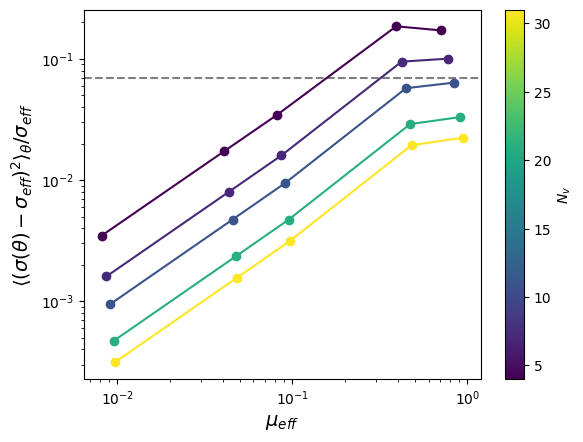

In [49]:
nv_norm = plt.Normalize(vmin=effective_geometry_data.nv.min(), vmax=effective_geometry_data.nv.max())
cmap = plt.cm.viridis

for nv in effective_geometry_data.nv.unique():
    mask = (effective_geometry_data.nv == nv)
    df = effective_geometry_data[mask]
    plt.plot(df.mu_eff, df.relative_rms_roughness_small, c=cmap(nv_norm(nv)), marker='o')
plt.axhline(0.07, zorder=0, linestyle='--', color='k', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mu_{eff}$', fontsize=14)
plt.ylabel(r'$\langle (\sigma(\theta) - \sigma_{eff})^2 \rangle_\theta / \sigma_{eff}$', fontsize=14)
sm = plt.cm.ScalarMappable(norm=nv_norm, cmap=cmap)
sm.set_array(effective_geometry_data.nv.unique().tolist())
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$N_v$')
plt.savefig('relative-rms-roughness.png', dpi=600)

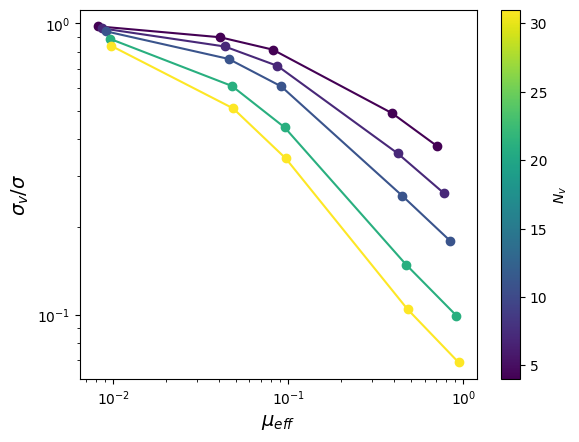

In [51]:
nv_norm = plt.Normalize(vmin=effective_geometry_data.nv.min(), vmax=effective_geometry_data.nv.max())
cmap = plt.cm.viridis

for nv in effective_geometry_data.nv.unique():
    mask = (effective_geometry_data.nv == nv)
    df = effective_geometry_data[mask]
    plt.plot(df.mu_eff, df.sigma_v_ratio_small, c=cmap(nv_norm(nv)), marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mu_{eff}$', fontsize=14)
plt.ylabel(r'$\sigma_v/\sigma$', fontsize=14)
sm = plt.cm.ScalarMappable(norm=nv_norm, cmap=cmap)
sm.set_array(effective_geometry_data.nv.unique().tolist())
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$N_v$')
plt.savefig('sigma_v_ratio.png', dpi=600)